# Semesterprojekt: Retourenvorhersage
Data Mining & Grundlagen Maschinelles Lernen 1, Wintersemester 2022/23

**Gruppe:**

|Paul|Antonio|Tim|Flo|
|---|---|---|---|
|hopa1029|coan1014|ehti1011|klfl1012|
80001|80327|80055|79679|

**Gliederung:**
1. Data Cleaning, Feature Engineering und Funktionen
   - 1.1 Data Cleaning
  
   - 1.2 Featrue Engineering
  
   - 1.3 Funktionen
   
2. Klassifikaitonsmodelle mit Hyperparameteroptimierung:
   - 2.1 Logistische Regression 
  
   - 2.2 Decision Tree Classifier
     - 2.2.1 Random Forest 
      
     - 2.2.2 Gradient Boosting   
   
  
   - 2.3 Super Vector Machine

                  
3. Evaluation mit ROC Plot 

4. Aufgabe 5

**Imports:**

In [1]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

**Original Datensatz:**

Der Datensatz beschreibt 75,007 bestellte Artikel, von denen bekannt ist, ob sie zurückge
sendet wurden oder nicht.  
Für einen bestellten Artikel (1 Zeile) existieren folgende Felder in den Daten:

- order_item_id: ID des bestellten Artikels
- order_date: Datum der Bestellung
- delivery_date: Lieferdatum des Artikels
- item_id: ID des Artikels
- item_size: Größe des Artikels
- item_color: Farbe des Artikels
- brand_id: Hersteller ID
- item_price: Preis des Artikels
- user_id: ID des Nutzers
- user_title: Titel des Nutzers
- user_dob: Geburtsdatum des Nutzers
- user_state: Bundesland, in dem der Nutzer wohnt
- user_reg_date: Datum, an dem sich der Nutzer registriert hat
- return: Wurde der Artikel zurückgeschickt (1) oder nicht (0)

In [2]:
df = pd.read_csv("retouren.csv")

In [23]:
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
3,4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
4,5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


## 1. Data Cleaning, Feature Engineering und Funktionen

### 1.1 Data Cleaning

Neue Testdaten müssen diese Verarbeitungsschritte durchlaufen (Data CLeaning und Feature Engineering)

**Löschen und Beheben von Datenfehlern und Inkonsistenten im Datensatz**

In [3]:
# Data Cleaning:

# Anpassen der Datentypen
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)

# Löschen der Datensätze mit Preis von 999
df = df.drop(df[df.item_price == 999].index)

# Löschen der Datensätze wo das Lieferdatum kleiner dem Bestelldatum
df = df.drop(df[df.delivery_date < df.order_date].index)

# Anpassen der Dateninkonsistenzen bei item_color
df = df.drop(df[df.item_color == "?"].index)
df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"

# Löschen der Datensätze ohne delivery_date
df.drop(df[df.delivery_date.isna()].index, inplace=True)

### 1.2 Feature Engineering

**Datensatz mit neuen Features:**

Der Datensatz wurde für die Modelle um folgenden Features erweitert:

- age: Alter der User zum Zeitpunkt der Bestellung, Differenz zwischen order_date und user_dob
- acc_age: Accountalter des Nutzers zum Zeitpunkt der Bestellung, (-) wenn nach der Bestellung regisrtiert
- maxprice: Der Maximalpreis eines Produktes
- markdown: Ist der Artikel im Vergleich zu maxprice vergünstig (1) oder nicht (0) 
- order_id: ID einer Bestellung
- order_size: Größe einer Bestellung
- return_ratio: Relative Häufigkeit wie oft eine Item zurückgegeben wurde in der Historie der Bestellungen, Wert zwischen 0 und 1
- user_return_raitio: RElative Häufigkeit wie oft ein User in der Historie ein Item zurückgegeben hat, Wert zwischen 0 und 1
- nth_order_of_user: Die wie vielte Bestellung eines Users
- item_id_>1_in_order: Anzahl der Item ID`s in einer Bestellung, falls diese mehrere hat
- item_id_ordered_previously. Gibt an ob ein Item ebenfalls in der vorherigen Bestellung ist (unter der Annahme das ein User nur einmal am Tag bestellt)

Annahme : Ein Kunde bestellt nur einmal pro Tag 

In [4]:
# Feature Engineering:

# age
df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))

# age bins
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

# acc_age
df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days

# maxprice and markdown
df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1

# order_id und order_size
order_id_generator = df.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

# return_ratio 
df_return_ratio = df.groupby("item_id").agg(returned = ("return", "sum"), item_order= ("return", "count")).reset_index()
df_return_ratio["not_returned"] = df_return_ratio.item_order - df_return_ratio.returned
df_return_ratio["return_ratio"] = df_return_ratio.returned / df_return_ratio.item_order
df_return_ratio.drop(["returned","item_order","not_returned"],axis=1,inplace=True)
df = pd.merge(df,df_return_ratio,on="item_id",how="left")

# user_return_ratio
df_user_return = df.groupby("user_id").agg(user_return= ("return", "sum"), user_orders= ("return", "count")).reset_index()
df_user_return["user_return_ratio"] = df_user_return.user_return / df_user_return.user_orders
df_user_return.drop(["user_return", "user_orders"], axis=1, inplace= True)
df = pd.merge(df, df_user_return, on= "user_id", how= "left")

# nth_order_of_user
df_nth_order_of_user = df.groupby(['user_id', 'order_id'], as_index=False).size().drop('size', axis=1)
df_nth_order_of_user['nth_order_of_user'] = df_nth_order_of_user.groupby(['user_id']).cumcount()+1
df = pd.merge(df,df_nth_order_of_user,on=['user_id', 'order_id'], how='left')

# item_id_>1_in_order
item_counts_in_order = df.groupby(['order_id', 'item_id'], as_index=False).size()
item_counts_in_order['item_id_>1_in_order'] = item_counts_in_order['size'] > 1
df = pd.merge(df,item_counts_in_order[['order_id', 'item_id', 'item_id_>1_in_order']],on=['order_id', 'item_id'], how='left')

# item_id_ordered_previously
df['item_id_ordered_previously'] = False
for index, row in df.iterrows():
    item_id = row['item_id']
    order_id = row['order_id']
    user_id = row['user_id']
    for i2, prev_row in df[df.user_id == user_id].iterrows():
        if prev_row['order_id'] == order_id: 
            break
        if prev_row['item_id'] == item_id: 
            df.loc[index, 'item_id_ordered_previously'] = True
            break

OneHotEncoding

In [5]:
enc = OneHotEncoder(handle_unknown='ignore',sparse = False) 
df_1 = enc.fit_transform(df[[ "item_color",	"user_title",	"user_state", "age", "item_size","item_id_>1_in_order" ]])
e = enc.categories_
a = []
for i in range(6):
    a = np.append(a,e[i])
a = [str(i) for i in a]
df_1 = pd.DataFrame(df_1,columns=a)
df = pd.concat([df,df_1],axis=1)
df.drop([ "item_color",	"user_title",	"user_state", "age", "item_size","item_id_>1_in_order" ],axis=1,inplace=True)

In [28]:
df.columns

Index(['order_item_id', 'order_date', 'delivery_date', 'item_id', 'brand_id',
       'item_price', 'user_id', 'user_dob', 'user_reg_date', 'return',
       ...
       'l', 'm', 's', 'unsized', 'xl', 'xs', 'xxl', 'xxxl', 'False', 'True'],
      dtype='object', length=222)

In [29]:
df.head()

,order_item_id,order_date,delivery_date,item_id,brand_id,item_price,user_id,user_dob,user_reg_date,return,...,l,m,s,unsized,xl,xs,xxl,xxxl,False,True
0,1,2016-06-22,2016-06-27,643,30,49.9,30822,1969-04-17,2016-06-23,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,763,2016-06-24,2016-06-26,643,30,49.9,29306,1973-06-17,2016-06-17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,2016-06-22,2016-06-27,270,49,79.9,30823,1970-04-22,2015-03-15,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,522,2016-06-23,2016-06-26,270,49,79.9,11260,1950-11-21,2015-04-24,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,25884,2016-07-03,2016-07-04,270,49,79.9,1283,1967-01-12,2015-09-15,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 1.3 Funktionen 

**Funktionen:**

Folgende Funktionen wurden programmiert:
- plot_cunfusion_matrix(): Plotten von Confusion Matrizen
- plot_roc_curve(): Plotten von einem oder mehreren ROC-Diagrammen
- print_evaluation(): Einheitliche Rückgabe von Accuracy-, Recall- und Precision-Score des verwendeten Modells
- calc_model_cost(): Kalkuliert die Kosten die man sich durch das Modell sparen kann oder anfallen 

In [6]:
# Funktionen

def plot_confusion_matrix(y_test, y_pred, color: str, colorbar: bool, normalize: str):
    """
    plot_confusion_matrix plottet eine Confusion Martrix in From der vergebenen Parametern.

    y_test (array): Label der Testdaten das es hervorzusagen gilt
    y_pred (array): Labels das tatsächlich hervorgesagt wurden
    color (str): Farbe der Confusion Matrix (Achtung!: nur ausgewählte Colorsets von sklearn/matplotlib)
    colorbar (bool): Soll eine Colorbar als Legende angezeigt werden, ja (True) und nein (False) 
    normalize (str): Sollen die Häufigkeiten relativ angezeigt werden, ja "true" neine "false"  

    """
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap= color, colorbar= colorbar, normalize= normalize)


def plot_roc_curve(X_test, y_test, y_predict):
    """ 
    plot_roc_curve erstellt für eine oder mehrere Modelle aus den angegebenen Parametern ein ROC-Diagramm.

    X_test (array): Features des Testdatensatzes
    y_test (array): Label des Testdatensatzes
    y_predict (array): Ein Array, mit einem oder mehreren Arrays drinnen, deren Values eine spezifische Reihenfolge besitzen: 1. Modell, 2. y_pred (tatsächliche hervorgesagte Labelwerte), 3. Titel/Anzeigename in der Graphik (str)    

    Beispielaufruf: plot_roc_curve(X_test= X_test, y_test= y_test, y_predict= [[best_gbc, y_pred_test_best_gbc, "GBC"], [best_dtc, y_pred_test_best_dtc, "DTC"]])
    """
    plt.figure(figsize= (20,10))
    
    for model in y_predict:
        fpr, tpr, thr = roc_curve(y_test, model[0].predict_proba(X_test)[:,1])
        auc = roc_auc_score(y_test, model[1])
        plt.step(x=fpr, y=tpr, label=f"{model[2]} (AUC = {auc.round(2)})")

    plt.legend()


def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    """ 
    print_evaluation gibt den Accuracy-, Recall- und Precision-Score des verwendeten Modells zurück.

    pipeline_or_mode (str): Pipeline oder Modellname
    X_train (array): Features des Trainingsdatensatzes
    X_test (array): Features des Testdatensatzes
    y_train (array): Label der Trainingsdaten das es hervorgzusagen gilt
    y_test (array): Label der Testdaten das es hervorzusagen gilt
    y_train_pred (array): Vorhergesagtes Label auf den Trainingsdaten
    y_test_pred (array): Vorhergesagtes Labl auf den Testdaten
    """
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )


def calc_model_cost(y_test,y_pred,X_test,Modelname: str):
    """
    Die Funktion calc_model_cost gibt einen String mit zurück, der das bestimmete Modell nennt und ihren Wert angibt, den Sie auf den Testdaten erzielen würde.

    y_test: label array der Testdaten
    y_pred: die label die das entsprechende Modell auf den Testdaten(testfeatures) hervorgesagt hat
    X_test: Features der Testdaten
    Modelname: Name des Model als string
    """
    df_aufgabe6 = X_test.copy()
    Modelname = Modelname
    df_aufgabe6["return_predict"] = y_pred
    df_aufgabe6["return_test"] = y_test
    df_aufgabe6["Abgleich"] = df_aufgabe6.return_predict == df_aufgabe6.return_test
    df_aufgabe6 = df_aufgabe6.drop(df_aufgabe6.loc[(df_aufgabe6.return_predict == 0)&(df_aufgabe6.Abgleich == True)].index)
    df_aufgabe6["summe"] = 0
    df_aufgabe6.loc[df_aufgabe6.Abgleich == True,"summe"]  = 3.5 # Wir sagen dass wir bei richtige Vorhersage ein Plus von 3.5€ erreichen
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 1),"summe"] = df_aufgabe6.item_price*(-0.1)*0.5 # bei fälschlicher Vorhersage einer Retoure gehen wir von einem Verlust von 50% des 10%tigen itemprice
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 0),"summe"] = -7 # beim nicht erkennen einer Retoure gehen wir von einem Verlust von 7€ aus
    print(f"Das Modell {Modelname} würde auf den jetzigen Testdaten einen Bonus von {df_aufgabe6.summe.sum().round(2)} erschaffen")

## 2. Klassifikaitonsmodelle mit Hyperparameteroptimierung

### Trainings- und Testdaten

In [7]:
df_classifier = df.copy()

# Festlegen von Featuren und Label
X = df_classifier.drop(["return","order_date","delivery_date","user_dob","user_reg_date"], axis=1)
y = df_classifier["return"]

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2.1 Logisitsche Regression

Mit der Methode StandardScaler die Daten skalieren und auf ihre Einheitsvarianz bringen

Machen eine Pipeline um uns den Code für die Skalierung (Standarscaler) zu vereinfachen

Hyperparametersuche mit einer 5-fachen Kreuzvalidierung durch GridSearchCV 
(Code dauert 1h)

In [8]:
pipe_lo = make_pipeline(StandardScaler(),
                     LogisticRegression(max_iter=500,dual=False)
                     )
param_grid_lo = {
"logisticregression__penalty": ["l1", "l2", "elasticnet"],
"logisticregression__C": np.linspace(0.01, 10, 10),
"logisticregression__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
 
}
lrc = GridSearchCV(pipe_lo,param_grid_lo,scoring="accuracy",n_jobs=2)
lrc.fit(X_train,y_train)

KeyboardInterrupt: 

In [9]:
print(f"Best parameters: {lrc.best_params_}, best score: {lrc.best_score_}")

Best parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}, best score: 0.7801392709306052


Ausführen des Classifiers mit den besten Parametern

In [10]:
best_lrc = LogisticRegression(penalty= "l1", C= 0.01, solver= "liblinear", max_iter= 1000)
best_lrc.fit(X_train, y_train)

y_pred_train_best_lrc = best_lrc.predict(X_train)
y_pred_test_best_lrc = best_lrc.predict(X_test)

print_evaluation("LogisticRegressionClassifier", X_train, X_test, y_train, y_test, y_pred_train_best_lrc, y_pred_test_best_lrc)

LogisticRegressionClassifier Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.77823 |        0.80211 |    0.76899 |    52888 |      219
Test      0.78044 |        0.79348 |    0.77709 |    13222 |      219



### 2.2 Decision Tree Classifier

#### Basismodell Decision Tree Classifier

Mittels einer 10-Fachen Kreuzvalidierung und Hyperparametertuning wird die beste Kombination aus Baumtiefe (max_depth) und minimaler Anzahl an benötigter Beispiele für einen Split (min_samples) gesucht:

In [11]:
min_samples = [2, 10, 20, 50, 100]
kf = KFold(n_splits= 10, shuffle= True, random_state= 1)
best_mean_score = 0
best_combination = dict(max_depth= None, min_samples= 2)

for depth in range(1,10):
 for min_sample in min_samples:
  scores = []
  classifier = DecisionTreeClassifier(max_depth= depth, min_samples_split= min_sample, random_state= 0)
  if classifier.fit(X_train, y_train).tree_.max_depth < depth:
   break
  score = np.mean(cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs= 1))
  scores.append(score)

  mean_score = np.mean(np.array(scores))
 if mean_score > best_mean_score:
  best_combination["max_depth"] = depth
  best_combination["min_samples"] = min_sample
  best_mean_score = mean_score

print(f"Best Mean_score: {best_mean_score}, Best Max_depth: {best_combination['max_depth']}, Best Min_samples_split: {best_combination['min_samples']}")

Best Mean_score: 0.7754121747845913, Best Max_depth: 6, Best Min_samples_split: 100


In [20]:
g1s_crossvalidation = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 6, 9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1,
 cv= 10
 ).fit(X_train, y_train)
 
print(f"Best parameters: {g1s_crossvalidation.best_params_}, best score: {g1s_crossvalidation.best_score_}")

Best parameters: {'max_depth': 6, 'min_samples_split': 50, 'random_state': 0}, best score: 0.7752986638554771


Auführen des Classifiers mit einer Baumtiefe von 5 und 100 Auteilungen 

In [18]:
best_dtc = DecisionTreeClassifier(max_depth= 6, min_samples_split= 20, random_state= 0)
best_dtc.fit(X_train, y_train)

y_pred_train_best_dtc = best_dtc.predict(X_train)
y_pred_test_best_dtc = best_dtc.predict(X_test)

print_evaluation("DecisionTreeClassifier", X_train, X_test, y_train, y_test, y_pred_train_best_dtc, y_pred_test_best_dtc)

DecisionTreeClassifier Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.77857 |        0.82441 |    0.75843 |    52888 |      219
Test      0.78271 |        0.82130 |    0.76597 |    13222 |      219



#### 2.2.1 Random Forest

Hyperparametersuche via Gridsearch.

Code dauert sehr lange zum Ausführen, da hier keine optimierte Klasse genommen wurde

In [ ]:
rfc = RandomForestClassifier()

parameters_rfc = {
    "n_estimators": [100, 150, 200, 300], "max_depth": [20, 30, 40],
    'max_features': [25, 40, 50], 'bootstrap': [True, False], 'oob_score': [False, True],
    'ccp_alpha': [0, 0.005, 0.01], 'criterion': ['gini', 'entropy']
      }
rfc_gscv = GridSearchCV(rfc, parameters_rfc, cv=5,n_jobs=-1,verbose=3)
rfc_gscv.fit(X_train, y_train)

Auführen des Classifiers mit den besten Hyperparamtern

In [14]:
rfc = RandomForestClassifier(ccp_alpha = 0, n_estimators=400, criterion='entropy', max_depth=30, max_features=35)
rfc.fit(X=X_train, y=y_train)
y_pred_train_best_rfc = rfc.predict(X_train)
y_pred_test_best_rfc = rfc.predict(X_test)

print_evaluation("RandomForest", X_train, X_test, y_train, y_test, y_pred_train_best_rfc, y_pred_test_best_rfc)

RandomForest Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.99981 |        1.00000 |    0.99963 |    52888 |      219
Test      0.76184 |        0.77868 |    0.75727 |    13222 |      219



#### 2.2.1 Gradient Boosting Classifier

Um die Parameterwerte zu finden, die die höchste Genauigkeit erzielen, wird auch hier die Kreuzvalidierungsmethode GridSearchCV verwendet:

In [15]:
gs_crossvalidation = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5,9], random_state= [1]),
 scoring= "accuracy",
 n_jobs= -1,
 cv= kf
 ).fit(X_train, y_train)
 
print(f"Best parameters: {gs_crossvalidation.best_params_}, best score: {gs_crossvalidation.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100, 'random_state': 1}, best score: 0.7810657141288015


Auführen des Classifiers mit den besten Hyperparamtern

In [16]:
best_gbc = HistGradientBoostingClassifier(max_iter= 100, max_depth= 9, random_state= 1, learning_rate= 0.1).fit(X_train, y_train)

y_pred_train_best_gbc = best_gbc.predict(X_train)
y_pred_test_best_gbc = best_gbc.predict(X_test)

print_evaluation("GradientBoostingClassifier", X_train, X_test, y_train, y_test, y_pred_train_best_gbc, y_pred_test_best_gbc)

GradientBoostingClassifier Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.79181 |        0.83230 |    0.77309 |    52888 |      219
Test      0.78604 |        0.81801 |    0.77238 |    13222 |      219



### 2.3 Super Vector Machine

Wir verwenden eine Pipeline damit alle unserer eingehenden Features erst normalisiert werden (erspart code).

Wir verwenden nur ein lineares Kernel, da dieses eine extra Funktion besitzt die auf Zeilen über 1000 optimiert ist.
Die anderen Kernels würden zu lange zum testen dauern.

Die Hyperparameter optimierung läuft über Gridsearch mit 5-facher Crossvalidierung.
Da wir nur des lineare Kernel behandeln optimieren wir nur den Regulasierungsparameter C

In [17]:
pipe = make_pipeline(StandardScaler(),
                     LinearSVC(tol=1e-5, dual=False, max_iter=10000)
                     )
param_grid = {
    "linearsvc__C": np.linspace(0.001, 3, 20),
}
grid = GridSearchCV(pipe,param_grid,scoring="accuracy",n_jobs=2,return_train_score=True)
grid.fit(X_train,y_train)
print(f"Best parameters: {grid.best_params_}, best score: {grid.best_score_}")

Best parameters: {'linearsvc__C': 0.1588421052631579}, best score: 0.7797989616092295


Anschließend wird der Classifier mit dem optimierten Hyperparameter ausgeführt

In [18]:
pipe_best = make_pipeline(StandardScaler(),
                     LinearSVC(tol=1e-5, dual=False, max_iter=10000, C=grid.best_params_['linearsvc__C'])
                     )
pipe_best.fit(X_train,y_train)
y_pred_train_best_svc = pipe_best.predict(X_train)
y_pred_test_best_svc = pipe_best.predict(X_test)

print_evaluation("LinearSVC", X_train, X_test, y_train, y_test, y_pred_train_best_svc, y_pred_test_best_svc)


LinearSVC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.78180 |        0.80630 |    0.77204 |    52888 |      219
Test      0.78188 |        0.79423 |    0.77885 |    13222 |      219



## 3. Evaluation mit ROC-Plot

Da die Methode LinearSVC keine Methode predictproba() hat nehmen wir einen Hilfclassifier namens CalibratedCalssifierCV.
Dieser ermöglicht dann die funktion predictproba anhand der decision funktion von LinearSVC.
Die accuracy Werte werden dadurch leicht schwächer, jedoch ist das für nur eine graphische Darstellung unserer Meinung nach vernachlässigbar

In [19]:
clf = CalibratedClassifierCV(pipe_best,cv="prefit")
clf.fit(X_train,y_train)
y_pred_test_best_clf = clf.predict(X_test)

**Für die Evaluation werden mittels eines ROC-Plost alle Klassifizierungsmodelle miteinander verglichen:**

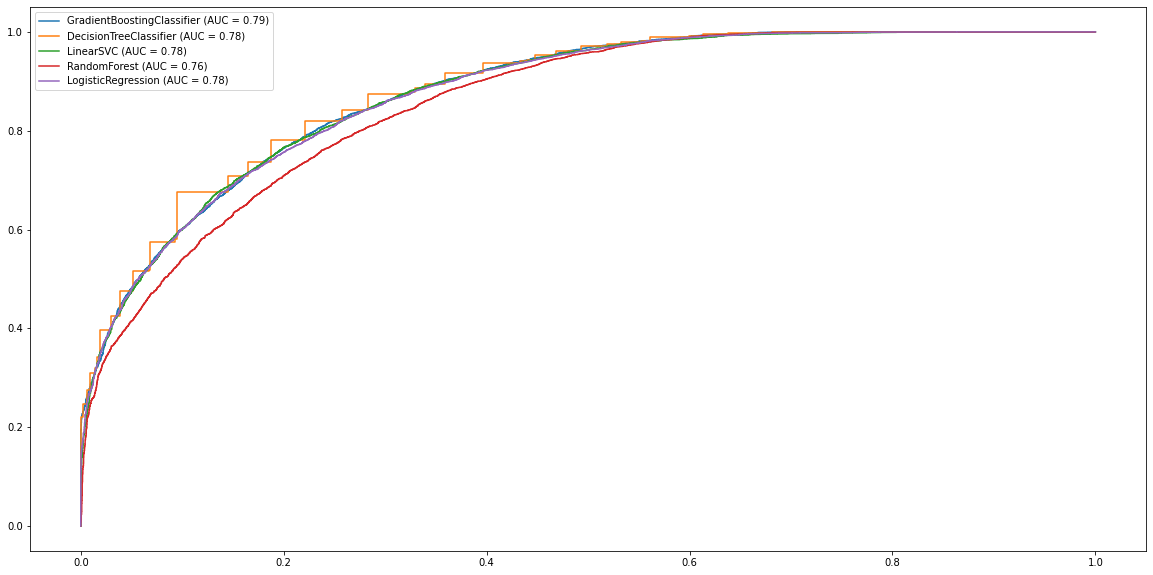

In [20]:
plot_roc_curve(X_test, y_test, 
 y_predict= [
  [best_gbc, y_pred_test_best_gbc, "GradientBoostingClassifier"],
  [best_dtc, y_pred_test_best_dtc, "DecisionTreeClassifier"],
  [clf, y_pred_test_best_clf, "LinearSVC"],
  [rfc, y_pred_test_best_rfc, "RandomForest"],
  [best_lrc, y_pred_test_best_lrc, "LogisticRegression"]
  ]
 )

- Alle Modelle liegen nicht nahe der Diagonale -> kein Zufallsprozess
- RandomForest overfitted auf den Trainingsdaten und deswegen schneidet dieser schlechter ab
- Modell DecisionTreeClassifier bei weniger Aufwand besser 

## 4. Aufgabe 6

Die beschriebenen Kostenfälle in der Aufgabenstellung lassen sich zu einer Confusion-Matrix zusammenfassen: 
- Wahrer Wert return: y_test (erste spalte) und Vorhergesagter Wert: y_predict (erste Zeile) 

|           | y_test                       |                           | 
|-----------|------------------------------|---------------------------|
| y_predict | 0                            | 1                         |
| 1         | (-) 10% * 50% vom item_price | (+) von 3,5€ (50% von 7€) |
| 0         | weder (+) noch (-)           | (-) 7€                    |

#### Logistische Regression

Das Modell LogisticRegression würde auf den jetzigen Testdaten einen Bonus von 3915.778499999999 erschaffen


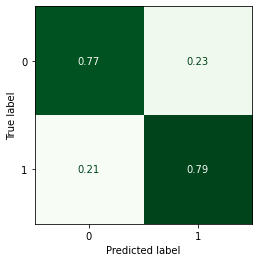

In [21]:
# Logitscche Regression Afg6:
plot_confusion_matrix(y_test, y_pred_test_best_lrc, color= "Greens", colorbar= False, normalize= "true")
calc_model_cost(y_test,y_pred_test_best_lrc,X_test,"LogisticRegression")

#### DecisionTreeClassifier

Das Modell DecisionTreeClassifier würde auf den jetzigen Testdaten einen Bonus von 5239.27 erschaffen


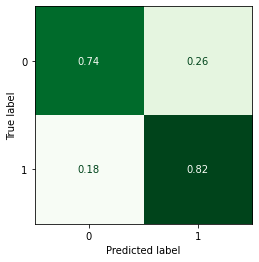

In [19]:
# DecisionTreeClassifier Afg6:
plot_confusion_matrix(y_test, y_pred_test_best_dtc, color= "Greens", colorbar= False, normalize= "true")
calc_model_cost(y_test,y_pred_test_best_dtc,X_test,"DecisionTreeClassifier")

#### GradientBoostingClassifier

Das Modell GradientBoostingClassifier würde auf den jetzigen Testdaten einen Bonus von 5171.800999999999 erschaffen


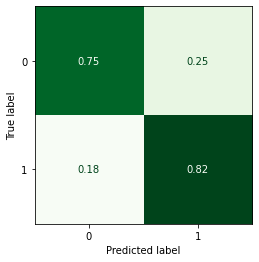

In [23]:
# GradientBoosintgClassifier Afg6:
plot_confusion_matrix(y_test, y_pred_test_best_gbc, color= "Greens", colorbar= False, normalize= "true")
calc_model_cost(y_test,y_pred_test_best_gbc,X_test,"GradientBoostingClassifier")

#### Random Forest

Das Modell RandomForest würde auf den jetzigen Testdaten einen Bonus von 2213.795999999999 erschaffen


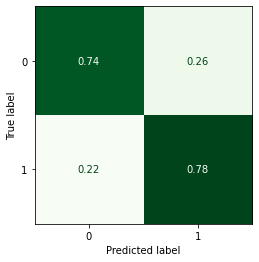

In [26]:
# RandomForest Afg6:
plot_confusion_matrix(y_test, y_pred_test_best_rfc, color= "Greens", colorbar= False, normalize= "true")
calc_model_cost(y_test,y_pred_test_best_rfc,X_test,"RandomForest")

#### Linear SVC 

Das Modell LinearSVC würde auf den jetzigen Testdaten einen Bonus von 4012.885999999999 erschaffen


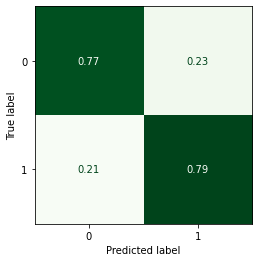

In [25]:
# LinearSVC Afg6:
plot_confusion_matrix(y_test, y_pred_test_best_svc, color= "Greens", colorbar= False, normalize= "true")
calc_model_cost(y_test,y_pred_test_best_svc,X_test,"LinearSVC")

#### **Kostenvergleich anhand Afg6:**

| Modell                     | Kosten |
|----------------------------|--------|
| Logistische Regression     |  3915.77      |
| DecisionTreeClassifier     |     5284.29   |
| GradientBoostingClassifier |   5171.80     |
| Random Forest              |    2213.79    |
| LinearSVC                  |    4012.88    |

-> nach dem Kostenvergleich ist DecisionTreeClassifier das beste Modell